In [1]:
import random
import pickle
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
# Here is the section dedicated to contatain the results of the sampling
# Purpose here is to try and use the UNET architecture and understand the
# first steps of building and training the neural network
sampled_pickles = '/home/omar/Desktop/sampled_output/'
smooth = 1.0

In [3]:
# First step is to choose random 26 patients as training pool. The
# remaining 3 are our test pool.

patients = os.listdir(sampled_pickles)
random.shuffle(patients)
# training_patients = patients[:26]
training_patients = ['TCGA-76-6282.pickle', 'TCGA-76-4932.pickle', 'TCGA-02-0046.pickle', 'TCGA-06-0138.pickle', 'TCGA-76-6657.pickle', 'TCGA-76-4935.pickle', 'TCGA-19-5960.pickle', 'TCGA-76-6280.pickle', 'TCGA-02-0006.pickle', 'TCGA-19-1789.pickle', 'TCGA-02-0009.pickle', 'TCGA-19-0963.pickle', 'TCGA-02-0086.pickle', 'TCGA-06-0149.pickle', 'TCGA-06-0179.pickle', 'TCGA-06-2570.pickle', 'TCGA-02-0075.pickle', 'TCGA-12-0616.pickle', 'TCGA-02-0085.pickle', 'TCGA-06-5417.pickle', 'TCGA-06-0145.pickle', 'TCGA-08-0355.pickle', 'TCGA-02-0054.pickle', 'TCGA-19-2624.pickle', 'TCGA-06-0177.pickle', 'TCGA-02-0106.pickle']
# test_patients = patients[26:29]
test_patients = ['TCGA-08-0509.pickle', 'TCGA-08-0520.pickle', 'TCGA-06-6389.pickle']
image_width = 256
image_height = 256
# batch_size= 16
current_dir = '/home/omar/Desktop/Generalization/Model/'

In [4]:
def prepare_data(path, list_of_patients):
    # Setting the lists that will contain the images and masks
    img_height = 256
    img_width = 256
    total_scans = 0
    seg = 0
    for patient in list_of_patients:
        patient_path = path + patient
        pickle_file = open("%s"%(patient_path), "rb")
        patient_data = pickle.load(pickle_file)
        total_scans += len(patient_data[0]) + len(patient_data[1]) + len(patient_data[2]) + len(patient_data[3])
    
    imgs = np.ndarray((total_scans, img_width, img_height), dtype = np.uint8)
    masks = np.ndarray((total_scans, img_width, img_height), dtype = np.uint8)
    
    indexer = 0
    for patient in list_of_patients:
        print('Current Patient: %s' % (patient))
        patient_path = path + patient
        pickle_file = open("%s"%(patient_path), "rb")
        patient_data = pickle.load(pickle_file)
        for scan in range(len(patient_data)):
            if scan != 4:
                for array in range(len(patient_data[scan])):
                    img = patient_data[scan][array]
                    img_mask = patient_data[4][scan][array]
                    imgs[indexer] = img
                    masks[indexer] = img_mask
                    indexer+=1
    os.chdir(current_dir)
    np.save('imgs_train.npy', imgs)
    np.save('img_masks_train.npy', masks)
    print('Images for training and masking saved to .npy files.')

    
def load_data():
    imgs = np.load('imgs_train.npy')
    masks = np.load('img_masks_train.npy')
    return imgs, masks



def preprocess(imgs):
    processed_images =np.ndarray((imgs.shape[0], image_width, image_height), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        processed_images[i] = resize(imgs[i], (image_width, image_height), preserve_range=True)
    
    processed_images = processed_images[..., np.newaxis]
    return processed_images



def prepare_test(path, list_of_patients):
    img_height = 256
    img_width = 256
    total_scans = 0
    seg = 0
    for patient in list_of_patients:
        patient_path = path + patient
        pickle_file = open("%s"%(patient_path), "rb")
        patient_data = pickle.load(pickle_file)
        total_scans += len(patient_data[0]) + len(patient_data[1]) + len(patient_data[2]) + len(patient_data[3])
    
    imgs = np.ndarray((total_scans, image_width, image_height), dtype = np.uint8)
    ids = np.ndarray((total_scans, ), dtype=np.int32)
    
    indexer = 0
    for patient in list_of_patients:
        print('Current Patient: %s' % (patient))
        patient_path = path + patient
        pickle_file = open("%s"%(patient_path), "rb")
        patient_data = pickle.load(pickle_file)
        for scan in range(len(patient_data)):
            if scan != 4:
                for array in range(len(patient_data[scan])):
                    img = patient_data[scan][array]
                    imgID = patient_data[4][scan][array]
                    imgs[indexer] = img
                    ids[indexer] = imgID
                    indexer+=1
    os.chdir(current_dir)
    np.save('imgs_test.npy', imgs)
    np.save('img_id_test.npy', ids)
    print('Images for testing and ids saved to .npy files.')
    

def load_test():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('img_id_test.npy')
    return imgs_test, imgs_id

In [5]:
# Updated preprocessing attempt
def preprocess_training(images):
    output = images.reshape(images.shape[0], 256, 256, 1)
    output = output.astype('float32')
    output/=255
    return output

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def UNet():
    inputs = Input((image_width, image_height, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#     Second Implementation
#     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

    return model

In [7]:
print('Training Dataset')
print(training_patients)
print("Test Dataset")
print(test_patients)

Training Dataset
['TCGA-76-6282.pickle', 'TCGA-76-4932.pickle', 'TCGA-02-0046.pickle', 'TCGA-06-0138.pickle', 'TCGA-76-6657.pickle', 'TCGA-76-4935.pickle', 'TCGA-19-5960.pickle', 'TCGA-76-6280.pickle', 'TCGA-02-0006.pickle', 'TCGA-19-1789.pickle', 'TCGA-02-0009.pickle', 'TCGA-19-0963.pickle', 'TCGA-02-0086.pickle', 'TCGA-06-0149.pickle', 'TCGA-06-0179.pickle', 'TCGA-06-2570.pickle', 'TCGA-02-0075.pickle', 'TCGA-12-0616.pickle', 'TCGA-02-0085.pickle', 'TCGA-06-5417.pickle', 'TCGA-06-0145.pickle', 'TCGA-08-0355.pickle', 'TCGA-02-0054.pickle', 'TCGA-19-2624.pickle', 'TCGA-06-0177.pickle', 'TCGA-02-0106.pickle']
Test Dataset
['TCGA-08-0509.pickle', 'TCGA-08-0520.pickle', 'TCGA-06-6389.pickle']


In [8]:
# Creating and saving data selected by randomizer.
print('-'*30)
print('Generating Data and masks')
print('-'*30)
prepare_data(sampled_pickles, training_patients)
print('-'*30)
print('Images and mask data created.')

------------------------------
Generating Data and masks
------------------------------
Current Patient: TCGA-76-6282.pickle
Current Patient: TCGA-76-4932.pickle
Current Patient: TCGA-02-0046.pickle
Current Patient: TCGA-06-0138.pickle
Current Patient: TCGA-76-6657.pickle
Current Patient: TCGA-76-4935.pickle
Current Patient: TCGA-19-5960.pickle
Current Patient: TCGA-76-6280.pickle
Current Patient: TCGA-02-0006.pickle
Current Patient: TCGA-19-1789.pickle
Current Patient: TCGA-02-0009.pickle
Current Patient: TCGA-19-0963.pickle
Current Patient: TCGA-02-0086.pickle
Current Patient: TCGA-06-0149.pickle
Current Patient: TCGA-06-0179.pickle
Current Patient: TCGA-06-2570.pickle
Current Patient: TCGA-02-0075.pickle
Current Patient: TCGA-12-0616.pickle
Current Patient: TCGA-02-0085.pickle
Current Patient: TCGA-06-5417.pickle
Current Patient: TCGA-06-0145.pickle
Current Patient: TCGA-08-0355.pickle
Current Patient: TCGA-02-0054.pickle
Current Patient: TCGA-19-2624.pickle
Current Patient: TCGA-06

In [9]:
# Loading data from npy files created.
print('-'*30)
print("Loading training dataset.")
print('-'*30)
imgs, masks = load_data()
# test_img, test_mask = load_test()
print('Data Loaded Successfully.')
print('-'*30)

------------------------------
Loading training dataset.
------------------------------
Data Loaded Successfully.
------------------------------


In [55]:
for i in masks:
    print(np.unique(i))

[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [59]:
print('-'*30)
print('Training with loaded data initiation.')
print('-'*30)
print('Preprocessing images and masks')

# Normalizing the data
img_final = preprocess_training(imgs)
mask_final = preprocess_training(masks)
# test_img_final = preprocess_training(test_img)
# test_mask_final = preprocess_training(test_mask)


# train_gen = ImageDataGenerator(rotation_range=8, 
#                                width_shift_range=0.08, 
#                                shear_range=0.3, 
#                                height_shift_range=0.08, 
#                                zoom_range=0.08 )
# test_gen = ImageDataGenerator()

# training_dataset = train_gen.flow(img_final, mask_final, batch_size=64)
# testing_dataset = train_gen.flow(test_img_final, test_mask_final, batch_size=64)

imgs_train = img_final.astype('float32')
# mean = np.mean(imgs_train)
# std = np.std(imgs_train)

# imgs_train -= mean
# imgs_train /= std
imgs_train/=255
# print(np.unique(imgs_train[5]))
masks_train = mask_final.astype('float32')
# masks_train /= 255

print('-'*30)
print('Compiling model.')
# print(img_final[0][10])



model = UNet()
model.summary()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

------------------------------
Training with loaded data initiation.
------------------------------
Preprocessing images and masks
[0.0000000e+00 1.5378702e-05 3.0757405e-05 4.6136101e-05 6.1514809e-05
 7.6893506e-05 9.2272203e-05 1.0765091e-04 1.2302962e-04 1.3840832e-04
 1.5378701e-04 1.6916571e-04 1.8454441e-04 1.9992310e-04 2.1530181e-04
 2.3068051e-04 2.4605924e-04 2.6143793e-04 2.7681663e-04 2.9219533e-04
 3.0757402e-04 3.2295272e-04 3.3833142e-04 3.5371011e-04 3.6908881e-04
 3.8446751e-04 3.9984621e-04 4.1522493e-04 4.3060363e-04 4.4598232e-04
 4.6136102e-04 4.7673972e-04 4.9211847e-04 5.0749717e-04 5.2287587e-04
 5.3825456e-04 5.5363326e-04 5.6901196e-04 5.8439065e-04 5.9976935e-04
 6.1514805e-04 6.3052675e-04 6.4590544e-04 6.6128414e-04 6.7666284e-04
 6.9204153e-04 7.0742023e-04 7.2279893e-04 7.3817762e-04 7.5355632e-04
 7.6893502e-04 7.8431371e-04 7.9969241e-04 8.1507111e-04 8.3044986e-04
 8.4582856e-04 8.6120726e-04 8.7658595e-04 8.9196465e-04 9.0734335e-04
 9.2272204e-04 9.

In [11]:
# model.fit_generator(training_dataset)

In [12]:
# for scan in range(5):
#     for array in range(5):
        
#         fig  = plt.figure(figsize=(5,5))
#         a = fig.add_subplot(1, 2, 1)
#         imgplot = plt.imshow(img_final[scan][array])

#         a = fig.add_subplot(1, 2, 2)
#         imgplot = plt.imshow(mask_final[scan][array])


In [31]:
# for slice in range(20):
#     plt.figure(figsize=(5,5))
#     plt.imshow(np.squeeze(masks_train[slice]), 'gray')
print(masks_train[0:3].shape)

(3, 256, 256, 1)


In [33]:
print('-'*30)
print('Fitting Data.')
print('-'*30)

model.fit(imgs_train[:2], masks_train[:2], batch_size=1, nb_epoch=1, verbose=1, shuffle=False,
              validation_split=0.2,
              callbacks=[model_checkpoint])
print('Fitting Complete.')

------------------------------
Fitting Data.
------------------------------
Train on 1 samples, validate on 1 samples
Epoch 1/1


/home/omar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


1/1 [==============================] - 1s 1s/step - loss: 1.0000 - dice_coef: 3.0683e-05 - val_loss: 1.0000 - val_dice_coef: 3.0706e-05
Fitting Complete.


In [35]:
imgs_mask_test = model.predict(imgs_train[:1], verbose=1)

1/1 [==============================] - 0s 328ms/step


In [50]:
print(np.unique(masks_train[20]))

[0.0000000e+00 1.5378702e-05]


[0.43900877 0.44123772 0.44228557 ... 0.5338805  0.5339406  0.5350271 ]


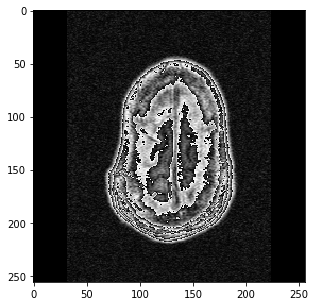

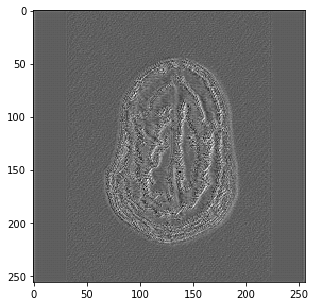

In [46]:
plt.figure(figsize=(5,5))
# print(imgs_train[0])
plt.imshow(np.squeeze(imgs_train[0]), 'gray')
plt.figure(figsize=(5,5))
plt.imshow(np.squeeze(imgs_mask_test), 'binary')


In [ ]:
# Generating the test patients

print('-'*30)
print('Creating Test Data.')
print('-'*30)
prepare_test(sampled_pickles, test_patients)
print('-'*30)

In [ ]:
# Loading and preprocessing the test patient data.
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test, imgs_id_test = load_test()

imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

print('-'*30)
print('Loading saved weights...')
print('-'*30)
model.load_weights('weights.h5')

In [ ]:
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1)
out_dir = '/home/omar/Desktop/Generalization/Model/OUT/'
os.chdir(out_dir)
np.save('imgs_mask_test.npy', imgs_mask_test)
print('-' * 30)
print('Saving predicted masks to files...')
print('-' * 30)
pred_dir = 'preds'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for image, image_id in zip(imgs_mask_test, imgs_id_test):
    ind = 1
    image = (image[:, :, 0] * 255.).astype(np.uint8)
    imsave(os.path.join(pred_dir, str(ind) + '_pred.png'), image)
    ind+=1